In [11]:
%matplotlib inline
import sys
sys.path.append("..")

In [12]:
import random

import deeptrack as dt

import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import tensorflow as tf

tracker_input_size = 64


In [13]:
class CrescentMoon(dt.Ellipse):
    def get(self, *inp, radius, offset, **kwargs):
        ellipse = super().get(*inp, radius=radius, **kwargs)
        offset = np.round(offset).astype(np.int)
        other = dt.Affine(translate=offset, mode="constant").resolve(ellipse)
        ellipse[np.array(other > 0)] = 0
        
        return ellipse
        
class Rectangle(dt.Scatterer):
    def get(self, *inp, width, height, **kwargs):
        return np.ones((round(width), round(height), 1))
        

In [14]:

commons = dt.DummyFeature(
    image_size=tracker_input_size,
    position=lambda image_size: image_size / 2 + np.random.randn(2) * 2
)

arguments = dt.Arguments(
    noise_level=lambda: 6 + np.random.rand() * 14,
    key=lambda: np.random.choice(["moon", "rect", "ellipse"]),
)

fluorescence_microscope = dt.Fluorescence(
    NA=1.1,                
    resolution=1e-6,     
    magnification=lambda: 7.5 + np.random.rand() * 5,
    wavelength=680e-9,
    output_region=(0, 0, tracker_input_size, tracker_input_size)
)

noise = dt.Poisson(snr=arguments.noise_level, background=0.2)

u = dt.units
moon_particle = CrescentMoon(radius=1e-6, offset=(6, 0), position=commons.position)
rectangle_particle = Rectangle(height=18, width=12, position=commons.position)
ellipse_particle = dt.Ellipse(radius=np.array((0.5, 1)) * u.um, position=commons.position)

particles = {
    "moon": moon_particle,
    "rect": rectangle_particle,
    "ellipse": ellipse_particle
}

particle = dt.OneOfDict(particles, key=arguments.key)

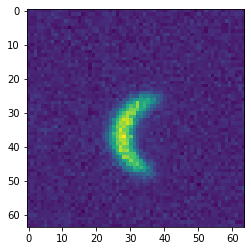

In [15]:


pipeline = (
    fluorescence_microscope(particle)
    >> dt.Affine(rotate=lambda:np.random.rand() * 2 * np.pi)
    >> dt.NormalizeMinMax() 
    + 0.2
) >> noise >> dt.NormalizeMinMax()

pipeline.bind_arguments(arguments)
pipeline.update().plot()

In [16]:
dataset = [pipeline.update().resolve() for _ in range(1000)]
dataset_labels = [np.mean(d.get_property("magnification", get_one=False), axis=0) for d in dataset]

In [17]:
def plot(xraw, diff, **kwargs):

    vmin = np.min(xraw)
    vmax = np.max(xraw)
    npoints = 10
    x = np.linspace(vmin, vmax, npoints)

    _x = xraw
    _y = np.abs(diff - np.mean(diff, axis=0))
    
    

    y = np.array([np.mean( _y[(_x >= x[i]) & (_x < x[i+1]) ], axis=0) for i in range(npoints-1)])

    plt.subplot(1, 2, 2)
    plt.plot(x[:npoints-1], y[:npoints-1, 0], **kwargs)
    plt.yscale("log")

    plt.title("Sizing error x")
    plt.ylabel(f"Absolute prediction error")
    plt.xlabel(f"Signal to noise")



In [20]:
from deeptrack.extras.radialcenter import radialcenter
import tensorflow.keras.backend as K
import tensorflow as tf
symmetries = 1
key = "ellipse"
noise_level = 20
magnification = 10

def size_consistency(T, P):
    T = K.reshape(T[:, :6], (-1, 2, 3))
    transformation_matrix = T[:, :2, :2]
    determinant = tf.linalg.det(transformation_matrix)
    
    P = P / P[:1]
    T = determinant

    err = K.square(P - T)
    return K.mean(err)


model = dt.models.AutoTracker(
    input_shape=(tracker_input_size, tracker_input_size, 1),
    mode="sizing",
    symmetries=1,
    loss=size_consistency
)


model_data = dt.Value(pipeline.update().resolve(key=key, noise_level=noise_level, magnification=10))


In [21]:
model.fit(model_data, epochs=30, batch_size=8)

Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 5s 6ms/step - loss: 4.8010
Epoch 2/30
800/800 [==============================] - 5s 6ms/step - loss: 2.2549
Epoch 3/30
800/800 [==============================] - 5s 6ms/step - loss: 2.7573
Epoch 4/30
800/800 [==============================] - 5s 6ms/step - loss: 2.0191
Epoch 5/30
800/800 [==============================] - 5s 6ms/step - loss: 2.1104
Epoch 6/30
800/800 [==============================] - 5s 6ms/step - loss: 2.2471
Epoch 7/30
800/800 [==============================] - 5s 6ms/step - loss: 1.8476
Epoch 8/30
800/800 [==============================] - 5s 6ms/step - loss: 2.3095
Epoch 9/30
800/800 [==============================] - 5s 6ms/step - loss: 2.1184
Epoch 10/30
800/800 [==============================] - 5s 6ms/step - loss: 2.7084
Epoch 11/30
800/800 [==============================] - 5s 6ms/step - loss: 2.1903
Epoch 12/30
800/800 [==============================] 

KeyboardInterrupt: 

In [ ]:
d = model.data_generator(model_data, batch_size=2)

with d:
    pass
x, y = d[0]

Generating 54 / 20 samples before starting training


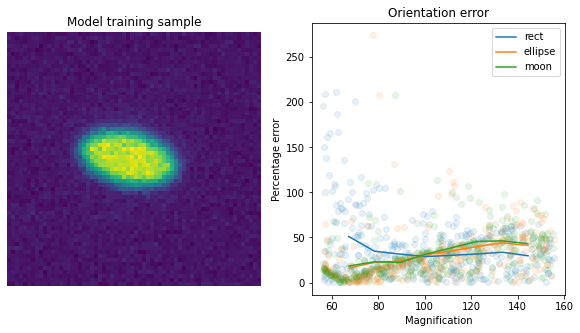

In [24]:

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(model_data())
plt.axis("off")
plt.title("Model training sample")

plt.subplot(1, 2, 2)

classification = [d.get_property("key") for d in dataset]
classes = set(classification)

for cl in classes:

    indexes = np.array(classification) == cl

    predicted_size = model.predict(np.array(dataset))[indexes][..., 0]



    _dataset_labels = np.array(dataset_labels)[indexes]

    mean_pred = np.mean(predicted_size)
    mean_lab = np.mean(_dataset_labels)

    scaled_prediction = predicted_size * mean_lab / mean_pred
    err =  np.abs((scaled_prediction - _dataset_labels) / _dataset_labels * 100)
    plt.scatter(_dataset_labels, err, alpha=0.1)
    xraw = _dataset_labels


    vmin = np.min(xraw)
    vmax = np.max(xraw)
    x = np.linspace(vmin, vmax, 10)

    _x = xraw
    _y = np.abs(err)

    y = [np.mean( _y[(_x >= x[i]) & (_x < x[i+1]) ]) for i in range(9)]
    plt.plot(x[1:9], y[1:9])

plt.title("Orientation error")
plt.ylabel(f"Percentage error")
plt.xlabel(f"Magnification")

plt.legend([x for x in classes])
plt.show()

In [ ]:
np.linalg.det(np.eye(2)*2)

4.0